In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors
from src.signal_categories import physics_category_labels, physics_category_colors
from src.signal_categories import filetype_category_labels, filetype_category_colors

from src.file_locations import intermediate_files_location


# File Loading

In [2]:
training = "first_combined_training"
#training = "first_wc_training"
#training = "first_lantern_training"

#training = "first_combined_physics_training"


In [3]:
print("loading all_df.pkl...")
with open(f"{intermediate_files_location}/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.pkl...")
with open(f"../training_outputs/{training}/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

print("merging all_df and predictions.pkl...")
merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")

sig_categories = topological_category_labels

prob_categories = ["prob_" + cat for cat in sig_categories]

for prob in prob_categories:
    merged_df[prob] = merged_df[prob].fillna(-1)


num_train_events = len(merged_df.query("used_for_training == True"))
num_test_events = len(merged_df.query("used_for_testing == True"))
print(f"{len(merged_df)=}")
print(f"{num_train_events=}")
print(f"{num_test_events=}")

frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = merged_df["used_for_testing"].to_numpy()
wc_net_weights = merged_df["wc_net_weight"].to_numpy()
for i in range(len(merged_df)):
    if used_for_testing[i]:
        modified_net_weights.append(wc_net_weights[i] / frac_test)
    else:
        modified_net_weights.append(wc_net_weights[i])
merged_df["wc_net_weight"] = modified_net_weights       

merged_df = merged_df.query("used_for_testing == True or not (used_for_testing == used_for_testing)") # include nans here as well, events which didn't pass pre-selection

merged_df["wc_truth_muonMomentum_3"] = [-1 if isinstance(x, float) else x[3] for x in merged_df["wc_truth_muonMomentum"].to_numpy()]

#erin_sig_query = "(wc_match_completeness_energy>0.1*wc_truth_energyInside and wc_truth_single_photon==1 and (wc_truth_isCC==0 or (wc_truth_isCC==1 and abs(wc_truth_nuPdg)==14 and abs(wc_truth_muonMomentum_3-0.105658)<0.1)))"
erin_sig_query = "(wc_truth_single_photon==1 and (wc_truth_isCC==0 or (wc_truth_isCC==1 and abs(wc_truth_nuPdg)==14 and abs(wc_truth_muonMomentum_3-0.105658)<0.1)))"
merged_df["erin_inclusive_1g_true_sig"] = merged_df.eval(erin_sig_query).astype(int)


loading all_df.pkl...
all_df.shape=(2171921, 210)
loading predictions.pkl...
pred_df.shape=(356805, 22)
merging all_df and predictions.pkl...
len(merged_df)=2171921
num_train_events=178402
num_test_events=178403
weighting up by the fraction of test events: 0.500


In [19]:
for col in all_df.columns:
    if "kine" in col:
        print(col)


wc_kine_reco_Enu


In [4]:
generic_merged_df = merged_df.query("wc_kine_reco_Enu > 0")
presel_merged_df = generic_merged_df.query("wc_shw_sp_n_20mev_showers > 0")

print(f"{merged_df.shape=}")
print(f"{generic_merged_df.shape=}")
print(f"{presel_merged_df.shape=}")


merged_df.shape=(1993519, 230)
generic_merged_df.shape=(311471, 230)
presel_merged_df.shape=(178403, 230)


In [5]:
wc_inclusive_selected_flag = []
shw_sp_n_20mev_showers_vals = presel_merged_df["wc_shw_sp_n_20mev_showers"].to_numpy()
reco_nuvtxX_vals = presel_merged_df["wc_reco_nuvtxX"].to_numpy()
reco_nuvtxY_vals = presel_merged_df["wc_reco_nuvtxY"].to_numpy()
reco_nuvtxZ_vals = presel_merged_df["wc_reco_nuvtxZ"].to_numpy()
single_photon_numu_score_vals = presel_merged_df["wc_single_photon_numu_score"].to_numpy()
single_photon_other_score_vals = presel_merged_df["wc_single_photon_other_score"].to_numpy()
single_photon_ncpi0_score_vals = presel_merged_df["wc_single_photon_ncpi0_score"].to_numpy()
single_photon_nue_score_vals = presel_merged_df["wc_single_photon_nue_score"].to_numpy()
shw_sp_n_20br1_showers_vals = presel_merged_df["wc_shw_sp_n_20br1_showers"].to_numpy()
for i in tqdm(range(len(presel_merged_df))):
    if (shw_sp_n_20mev_showers_vals[i] > 0
         and reco_nuvtxX_vals[i] > 5.0 and reco_nuvtxX_vals[i] < 250.0
           and single_photon_numu_score_vals[i] > 0.4 and single_photon_other_score_vals[i] > 0.2
             and single_photon_ncpi0_score_vals[i] > -0.05 and single_photon_nue_score_vals[i] > -1.0
               and shw_sp_n_20br1_showers_vals[i] == 1):
        wc_inclusive_selected_flag.append(1)
    else:
        wc_inclusive_selected_flag.append(0)
presel_merged_df["erin_inclusive_1g_sel"] = wc_inclusive_selected_flag


  0%|          | 0/178403 [00:00<?, ?it/s]

/tmp/ipykernel_2804319/2650567077.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presel_merged_df["erin_inclusive_1g_sel"] = wc_inclusive_selected_flag


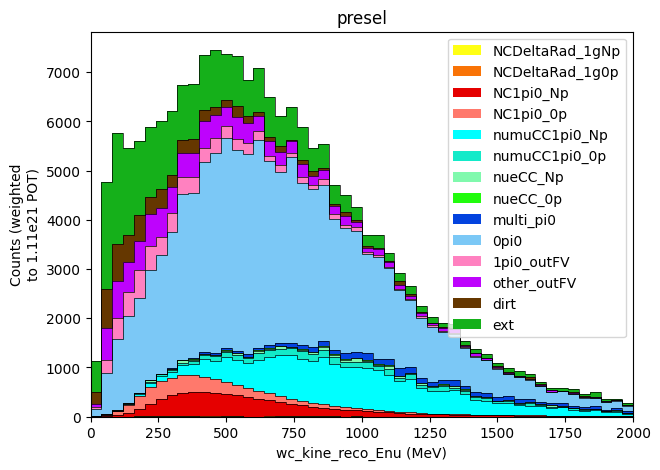

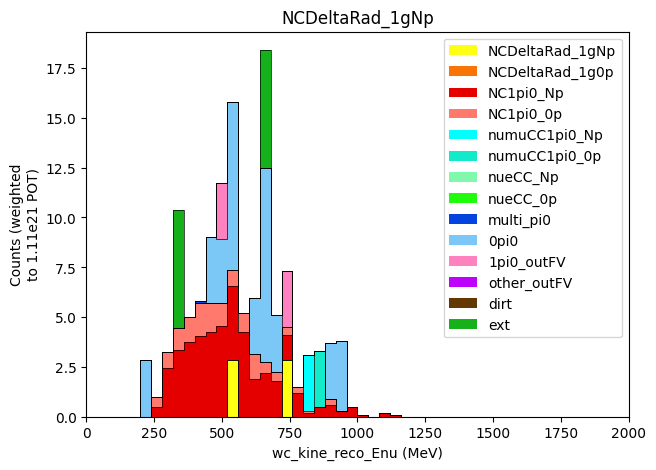

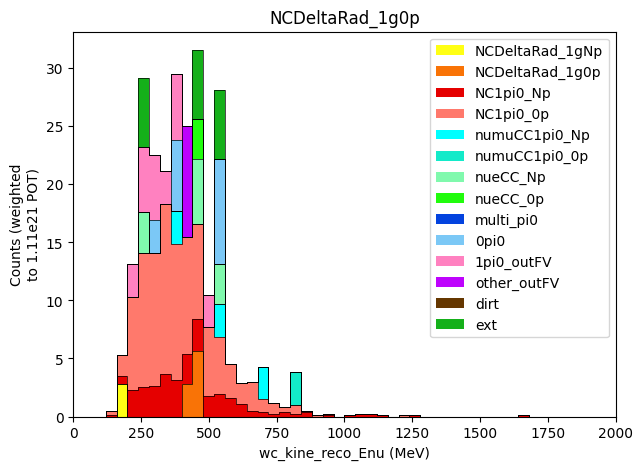

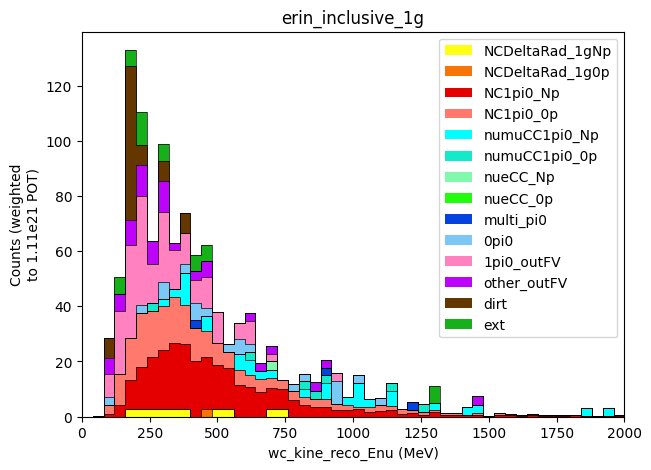

In [6]:
# plotting NC Delta Rad 1gNp vs 1g0p and Erin Inclusive 1g selections

for sel in ["presel", "NCDeltaRad_1gNp", "NCDeltaRad_1g0p", "erin_inclusive_1g"]:
    for breakdown_type in ["physics"]: #["topological", "physics", "filetype"]:
        if breakdown_type == "topological":
            breakdown_labels = topological_category_labels
            breakdown_colors = topological_category_colors
            breakdown_queries = []
            for label in breakdown_labels:
                breakdown_queries.append(f"topological_signal_category == '{label}'")
        elif breakdown_type == "physics":
            breakdown_labels = physics_category_labels
            breakdown_colors = physics_category_colors
            breakdown_queries = []
            for label in breakdown_labels:
                breakdown_queries.append(f"physics_signal_category == '{label}'")
        elif breakdown_type == "filetype":
            breakdown_labels = filetype_category_labels
            breakdown_colors = filetype_category_colors
            breakdown_queries = []
            for label in breakdown_labels:
                breakdown_queries.append(f"filetype == '{label}'")
        else:
            raise ValueError("Invalid breakdown type")

        plt.figure(figsize=(7, 5))

        bins = np.linspace(0, 2000, 51)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        multi_bin_centers = [bin_centers] * len(breakdown_labels)
        outline_colors = ["k"] * len(breakdown_labels)

        if sel == "presel":
            sel_df = presel_merged_df
        elif sel == "NCDeltaRad_1gNp":
            sel_df = presel_merged_df.query("wc_kine_reco_Enu > 0 and wc_nc_delta_score > 2.61 and wc_reco_num_protons>0")
        elif sel == "NCDeltaRad_1g0p":
            sel_df = presel_merged_df.query("wc_kine_reco_Enu > 0 and wc_nc_delta_score > 2.61 and wc_reco_num_protons==0")
        elif sel == "erin_inclusive_1g":
            sel_df = presel_merged_df.query("erin_inclusive_1g_sel == 1")
        else:
            raise ValueError("Invalid selection")
        
        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["wc_kine_reco_Enu"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])

        plt.hist(multi_bin_centers, weights=counts, bins=bins, color=breakdown_colors, stacked=True, label=breakdown_labels)
        plt.hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)

        plt.xlabel(r"wc_kine_reco_Enu (MeV)")
        plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
        plt.xlim(bins[0], bins[-1])
        plt.legend(loc="upper right")
        plt.title(sel)
        plt.show()


In [7]:
probs_2d_arr = presel_merged_df[prob_categories].to_numpy()
reco_categories_argmax = np.argmax(probs_2d_arr, axis=1)
presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax

# assign a string to reco_category column according to the index and the list sig_categories

presel_merged_df["reco_category"] = [sig_categories[i] for i in reco_categories_argmax]


/tmp/ipykernel_2804319/963365609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax
/tmp/ipykernel_2804319/963365609.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presel_merged_df["reco_category"] = [sig_categories[i] for i in reco_categories_argmax]


# Preselection Efficiencies

In [8]:
breakdown_queries = []
for label in topological_category_labels:
    breakdown_queries.append(f"topological_signal_category == '{label}'")

total_num_truth_by_category = [np.sum(merged_df.query(query)["wc_net_weight"]) for query in breakdown_queries]
total_num_generic_truth_by_category = [np.sum(generic_merged_df.query(query)["wc_net_weight"]) for query in breakdown_queries]
total_num_presel_truth_by_category = [np.sum(presel_merged_df.query(query)["wc_net_weight"]) for query in breakdown_queries]

print("WC Generic Selection Topological Efficiencies:")
for i in range(len(topological_category_labels)):
    print(f"{topological_category_labels[i]}: {total_num_generic_truth_by_category[i]} / {total_num_truth_by_category[i]} = {total_num_generic_truth_by_category[i] / total_num_truth_by_category[i]:.3f}")

print("\nPreselection Topological Efficiencies:")
for i in range(len(topological_category_labels)):
    print(f"{topological_category_labels[i]}: {total_num_presel_truth_by_category[i]} / {total_num_truth_by_category[i]} = {total_num_presel_truth_by_category[i] / total_num_truth_by_category[i]:.3f}")


WC Generic Selection Topological Efficiencies:
1gNp: 1258.1912235557038 / 2442.226642456372 = 0.515
1g0p: 603.8846021208074 / 1643.0540118075605 = 0.368
1gNp1mu: 3724.2731921095155 / 5528.631112376388 = 0.674
1g0p1mu: 673.7163723944499 / 1073.4335581089433 = 0.628
1g_outFV: 3949.3096244555873 / 19594.636250048155 = 0.202
2gNp: 8614.394425331784 / 12322.961859711617 = 0.699
2g0p: 5151.005535700824 / 8403.663377221097 = 0.613
2gNp1mu: 23535.16198620421 / 29345.557392930863 = 0.802
2g0p1mu: 4400.869872329602 / 5740.370359105014 = 0.767
2g_outFV: 2745.6403663922774 / 8459.676229124192 = 0.325
1eNp: 1587.6439085085435 / 1978.133067430229 = 0.803
1e0p: 346.6399601529836 / 474.57572520643123 = 0.730
0g: 440475.0689171847 / 1744842.1813996949 = 0.252
3plusg: 6029.097080683112 / 7975.662568048147 = 0.756
dirt: 21697.449952327042 / 799562.6691933963 = 0.027
ext: 73821.60290347115 / 6438209.09598104 = 0.011

Preselection Topological Efficiencies:
1gNp: 883.3623688287913 / 2442.226642456372 = 0.36

# Argmax Efficiencies

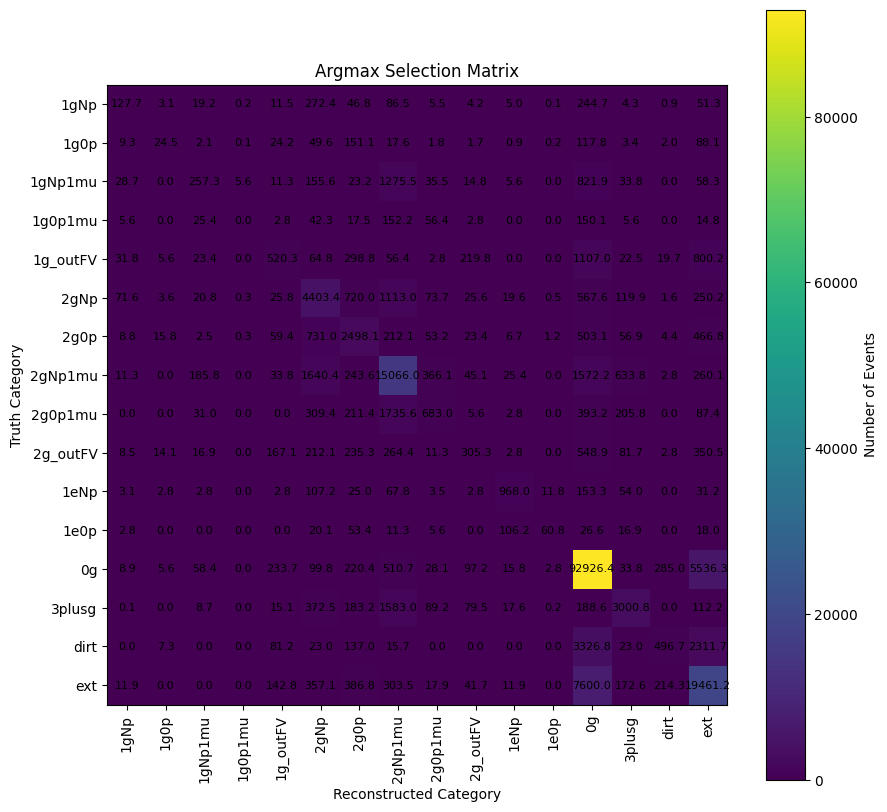

In [9]:
argmax_sel_matrix = np.zeros((len(topological_category_labels), len(topological_category_labels)))
for i in range(len(topological_category_labels)):
    for j in range(len(topological_category_labels)):
        argmax_sel_matrix[i, j] = presel_merged_df.query(f"topological_signal_category == '{topological_category_labels[i]}' and reco_category_argmax_index == {j}")["wc_net_weight"].sum()

plt.figure(figsize=(10, 10))
plt.imshow(argmax_sel_matrix)
plt.colorbar(label="Number of Events")
for i in range(len(topological_category_labels)):
    for j in range(len(topological_category_labels)):
        plt.text(j, i, f'{argmax_sel_matrix[i,j]:.1f}', ha='center', va='center', fontsize=8)
plt.xticks(range(len(topological_category_labels)), topological_category_labels, rotation=90)
plt.yticks(range(len(topological_category_labels)), topological_category_labels)
plt.xlabel("Reconstructed Category")
plt.ylabel("Truth Category")
plt.title("Argmax Selection Matrix")
plt.show()


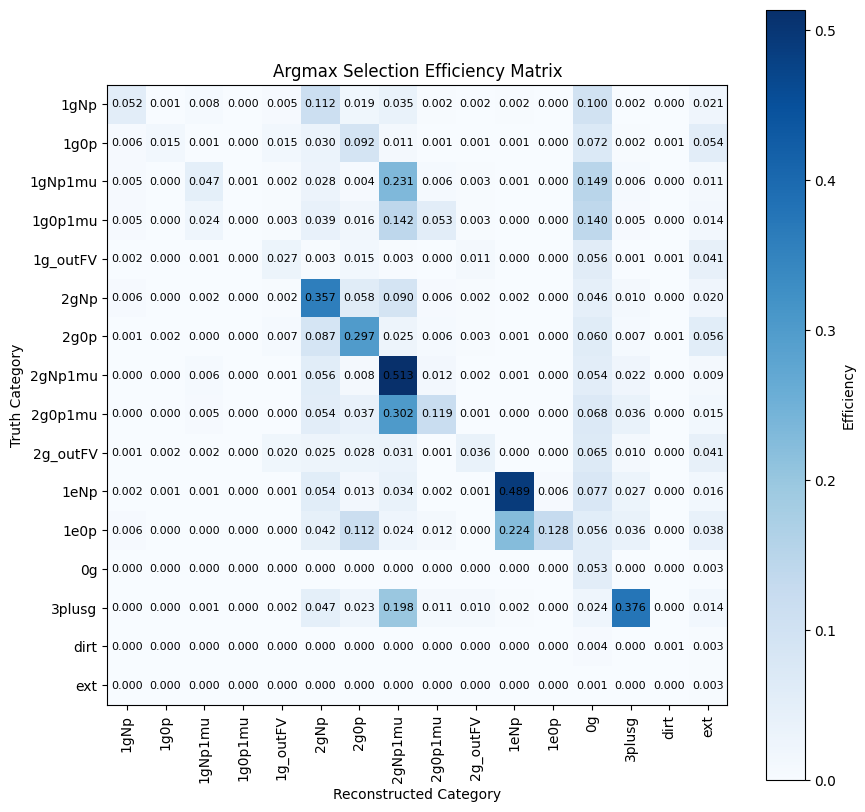

In [10]:
argmax_eff_matrix = (argmax_sel_matrix.T / total_num_truth_by_category).T

plt.figure(figsize=(10, 10))
plt.imshow(argmax_eff_matrix, cmap="Blues")
plt.colorbar(label="Efficiency")
for i in range(len(topological_category_labels)):
    for j in range(len(topological_category_labels)):
        plt.text(j, i, f'{argmax_eff_matrix[i,j]:.3f}', ha='center', va='center', fontsize=8)
plt.xticks(range(len(topological_category_labels)), topological_category_labels, rotation=90)
plt.yticks(range(len(topological_category_labels)), topological_category_labels)
plt.xlabel("Reconstructed Category")
plt.ylabel("Truth Category")
plt.title("Argmax Selection Efficiency Matrix")
plt.show()

# 1g Efficiencies By Cut Value

In [11]:
presel_merged_df["prob_1g_combined"] = (presel_merged_df["prob_1gNp"] 
                                      + presel_merged_df["prob_1g0p"]
                                      + presel_merged_df["prob_1gNp1mu"]
                                      + presel_merged_df["prob_1g0p1mu"]
                                      + presel_merged_df["prob_1g_outFV"])

presel_merged_df.loc[merged_df["wc_kine_reco_Enu"] < 0, "wc_nc_delta_score_generic"] = -999
presel_merged_df.loc[merged_df["wc_nc_delta_score"].isna(), "wc_nc_delta_score_generic"] = -999


/tmp/ipykernel_2804319/3914551325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presel_merged_df["prob_1g_combined"] = (presel_merged_df["prob_1gNp"]
/tmp/ipykernel_2804319/3914551325.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presel_merged_df.loc[merged_df["wc_kine_reco_Enu"] < 0, "wc_nc_delta_score_generic"] = -999


In [ ]:
# for each 1g category, as well as combined 1g categories:
# eff vs pur as function of cut value
# compare with NC Delta selection curve
# compare with Erin inclusive 1g curve and point
# maybe ask Mark about including the gLEE point? Might be totally different with nugraph...

plt.rcParams.update({'font.size': 14})

eff_eval_cats = ["NCDeltaRad_1gNp", "NCDeltaRad_1g0p", "1gNp", "1g0p", "1gNp1mu", "1g0p1mu", "1g_outFV", "1g_combined", "erin_inclusive_1g", "1eNp", "1e0p"]
eff_eval_cats = ["2gNp", "2g0p"]

if "physics" in training:
    eff_eval_cats = ["NCDeltaRad_1gNp", "NCDeltaRad_1g0p"]

for eff_eval_cat in eff_eval_cats:

    if eff_eval_cat == "1g_combined":

        all_sig_df = merged_df.query(f"""
           topological_signal_category == '1gNp'
        or topological_signal_category == '1g0p'
        or topological_signal_category == '1gNp1mu'
        or topological_signal_category == '1g0p1mu'
        or topological_signal_category == '1g_outFV'
        """.strip().replace("\n", ""))

        all_bkg_df = merged_df.query(f"""
            topological_signal_category != '1gNp'
        and topological_signal_category != '1g0p'
        and topological_signal_category != '1gNp1mu'
        and topological_signal_category != '1g0p1mu'
        and topological_signal_category != '1g_outFV'
        """.strip().replace("\n", ""))

        sig_df = presel_merged_df.query(f"""
            topological_signal_category == '1gNp'
        or topological_signal_category == '1g0p'
        or topological_signal_category == '1gNp1mu'
        or topological_signal_category == '1g0p1mu'
        or topological_signal_category == '1g_outFV'
        """.strip().replace("\n", ""))

        bkg_df = presel_merged_df.query(f"""
            topological_signal_category != '1gNp'
        and topological_signal_category != '1g0p'
        and topological_signal_category != '1gNp1mu'
        and topological_signal_category != '1g0p1mu'
        and topological_signal_category != '1g_outFV'
        """.strip().replace("\n", ""))

        total_sig = np.sum(all_sig_df["wc_net_weight"])
        total_bkg = np.sum(bkg_df["wc_net_weight"])

    elif eff_eval_cat == "erin_inclusive_1g":
        all_sig_df = merged_df.query(f"erin_inclusive_1g_true_sig == 1")
        all_bkg_df = merged_df.query(f"erin_inclusive_1g_true_sig == 0")
        sig_df = presel_merged_df.query(f"erin_inclusive_1g_true_sig == 1")
        bkg_df = presel_merged_df.query(f"erin_inclusive_1g_true_sig == 0")
        total_sig = np.sum(all_sig_df["wc_net_weight"])
        total_bkg = np.sum(all_bkg_df["wc_net_weight"])

    elif eff_eval_cat == "NCDeltaRad_1gNp":
        all_sig_df = merged_df.query(f"physics_signal_category == 'NCDeltaRad_1gNp'")
        all_bkg_df = merged_df.query(f"physics_signal_category != 'NCDeltaRad_1gNp'")
        sig_df = presel_merged_df.query(f"physics_signal_category == 'NCDeltaRad_1gNp'")
        bkg_df = presel_merged_df.query(f"physics_signal_category != 'NCDeltaRad_1gNp'")
        total_sig = np.sum(all_sig_df["wc_net_weight"])
        total_bkg = np.sum(all_bkg_df["wc_net_weight"])
    elif eff_eval_cat == "NCDeltaRad_1g0p":
        all_sig_df = merged_df.query(f"physics_signal_category == 'NCDeltaRad_1g0p'")
        all_bkg_df = merged_df.query(f"physics_signal_category != 'NCDeltaRad_1g0p'")
        sig_df = presel_merged_df.query(f"physics_signal_category == 'NCDeltaRad_1g0p'")
        bkg_df = presel_merged_df.query(f"physics_signal_category != 'NCDeltaRad_1g0p'")
        total_sig = np.sum(all_sig_df["wc_net_weight"])
        total_bkg = np.sum(all_bkg_df["wc_net_weight"])

    else:
        all_sig_df = merged_df.query(f"topological_signal_category == '{eff_eval_cat}'")
        all_bkg_df = merged_df.query(f"topological_signal_category != '{eff_eval_cat}'")
        sig_df = presel_merged_df.query(f"topological_signal_category == '{eff_eval_cat}'")
        bkg_df = presel_merged_df.query(f"topological_signal_category != '{eff_eval_cat}'")
        total_sig = np.sum(all_sig_df["wc_net_weight"])
        total_bkg = np.sum(all_bkg_df["wc_net_weight"])

    multi_class_bdt_score_name = f"prob_{eff_eval_cat}"
    if eff_eval_cat == "erin_inclusive_1g":
        multi_class_bdt_score_name = "prob_1g_combined"
    if eff_eval_cat == "NCDeltaRad_1gNp":
        multi_class_bdt_score_name = "prob_1gNp"
    if eff_eval_cat == "NCDeltaRad_1g0p":
        multi_class_bdt_score_name = "prob_1g0p"

    if "physics" in training and eff_eval_cat == "NCDeltaRad_1gNp":
        multi_class_bdt_score_name = "prob_NCDeltaRad_1gNp"
    if "physics" in training and eff_eval_cat == "NCDeltaRad_1g0p":
        multi_class_bdt_score_name = "prob_NCDeltaRad_1g0p"

    sig_bdt_scores = sig_df[multi_class_bdt_score_name].to_numpy()
    bkg_bdt_scores = bkg_df[multi_class_bdt_score_name].to_numpy()
    sig_weights = sig_df["wc_net_weight"].to_numpy()
    bkg_weights = bkg_df["wc_net_weight"].to_numpy()

    num_points = 1000
    #all_bdt_scores = np.concatenate([sig_bdt_scores, bkg_bdt_scores])
    #good_bdt_scores = all_bdt_scores[all_bdt_scores >= 0]
    #cutoffs = np.quantile(good_bdt_scores, np.linspace(0, 1, num_points))
    #cutoffs = np.concatenate([[0], cutoffs, [1]])
    cutoffs = np.linspace(0, 1, num_points)
    all_effs = []
    all_purs = []
    for cutoff in cutoffs:
        sig_sel_weights = sig_weights[sig_bdt_scores > cutoff]
        sig_sel = np.sum(sig_sel_weights)
        bkg_sel_weights = bkg_weights[bkg_bdt_scores > cutoff]
        bkg_sel = np.sum(bkg_sel_weights)
        eff = sig_sel / total_sig if total_sig > 0 else np.nan
        pur = sig_sel / (sig_sel + bkg_sel) if sig_sel + bkg_sel > 0 else np.nan
        all_effs.append(eff)
        all_purs.append(pur)

    if eff_eval_cat in ["1gNp", "1g0p", "1gNp1mu", "1g0p1mu", "1g_outFV", "1g_combined", "1eNp", "1e0p"]:

        if eff_eval_cat != "1g_combined":
            sig_reco_categories = sig_df["reco_category"].to_numpy()
            max_score_sig_sel_weights = sig_weights[sig_reco_categories == eff_eval_cat]
            max_score_sig_sel = np.sum(max_score_sig_sel_weights)
            bkg_reco_categories = bkg_df["reco_category"].to_numpy()    
            max_score_bkg_sel_weights = bkg_weights[bkg_reco_categories == eff_eval_cat]
            max_score_bkg_sel = np.sum(max_score_bkg_sel_weights)
            max_score_eff = max_score_sig_sel / total_sig if total_sig > 0 else np.nan
            max_score_pur = max_score_sig_sel / (max_score_sig_sel + max_score_bkg_sel) if max_score_sig_sel + max_score_bkg_sel > 0 else np.nan
        else:
            sig_reco_categories = sig_df["reco_category"].to_numpy()
            max_score_sig_sel_weights = sig_weights[np.logical_or(sig_reco_categories == "1gNp", np.logical_or(sig_reco_categories == "1g0p", np.logical_or(sig_reco_categories == "1gNp1mu", np.logical_or(sig_reco_categories == "1g0p1mu", sig_reco_categories == "1g_outFV"))))]
            max_score_sig_sel = np.sum(max_score_sig_sel_weights)
            bkg_reco_categories = bkg_df["reco_category"].to_numpy()
            max_score_bkg_sel_weights = bkg_weights[np.logical_or(bkg_reco_categories == "1gNp", np.logical_or(bkg_reco_categories == "1g0p", np.logical_or(bkg_reco_categories == "1gNp1mu", np.logical_or(bkg_reco_categories == "1g0p1mu", bkg_reco_categories == "1g_outFV"))))]
            max_score_bkg_sel = np.sum(max_score_bkg_sel_weights)
            max_score_eff = max_score_sig_sel / total_sig if total_sig > 0 else np.nan
            max_score_pur = max_score_sig_sel / (max_score_sig_sel + max_score_bkg_sel) if max_score_sig_sel + max_score_bkg_sel > 0 else np.nan

    sig_nc_delta_bdt_scores = sig_df["wc_nc_delta_score"].to_numpy()
    bkg_nc_delta_bdt_scores = bkg_df["wc_nc_delta_score"].to_numpy()
    sig_wc_reco_num_protons = sig_df["wc_reco_num_protons"].to_numpy()
    bkg_wc_reco_num_protons = bkg_df["wc_reco_num_protons"].to_numpy()
    sig_wc_match_isFCs = sig_df["wc_match_isFC"].to_numpy()
    bkg_wc_match_isFCs = bkg_df["wc_match_isFC"].to_numpy()
    all_nc_delta_bdt_scores = np.concatenate([sig_nc_delta_bdt_scores, bkg_nc_delta_bdt_scores])
    good_nc_delta_bdt_scores = all_nc_delta_bdt_scores[all_nc_delta_bdt_scores == all_nc_delta_bdt_scores]
    min_delta_score, max_delta_score = np.min(good_nc_delta_bdt_scores), np.max(good_nc_delta_bdt_scores)
    cutoffs = np.linspace(min_delta_score, max_delta_score, num_points)
    all_effs_nc_delta_Xp = []
    all_purs_nc_delta_Xp = []
    all_effs_nc_delta_Np = []
    all_purs_nc_delta_Np = []
    all_effs_nc_delta_0p = []
    all_purs_nc_delta_0p = []
    for cutoff in cutoffs:
        sig_sel_weights = sig_weights[np.logical_and(sig_nc_delta_bdt_scores > cutoff, sig_wc_match_isFCs == 1)]
        sig_sel = np.sum(sig_sel_weights)
        bkg_sel_weights = bkg_weights[np.logical_and(bkg_nc_delta_bdt_scores > cutoff, bkg_wc_match_isFCs == 1)]
        bkg_sel = np.sum(bkg_sel_weights)
        eff = sig_sel / total_sig if total_sig > 0 else np.nan
        pur = sig_sel / (sig_sel + bkg_sel) if sig_sel + bkg_sel > 0 else np.nan
        all_effs_nc_delta_Xp.append(eff)
        all_purs_nc_delta_Xp.append(pur)
        Np_sig_sel_weights = sig_weights[np.logical_and(np.logical_and(sig_nc_delta_bdt_scores > cutoff, sig_wc_match_isFCs == 1), sig_wc_reco_num_protons > 0)]
        Np_sig_sel = np.sum(Np_sig_sel_weights)
        Np_bkg_sel_weights = bkg_weights[np.logical_and(np.logical_and(bkg_nc_delta_bdt_scores > cutoff, bkg_wc_match_isFCs == 1), bkg_wc_reco_num_protons > 0)]
        Np_bkg_sel = np.sum(Np_bkg_sel_weights)
        Np_eff = Np_sig_sel / total_sig if total_sig > 0 else np.nan
        Np_pur = Np_sig_sel / (Np_sig_sel + Np_bkg_sel) if Np_sig_sel + Np_bkg_sel > 0 else np.nan
        all_effs_nc_delta_Np.append(Np_eff)
        all_purs_nc_delta_Np.append(Np_pur)
        zero_p_sig_sel_weights = sig_weights[np.logical_and(np.logical_and(sig_nc_delta_bdt_scores > cutoff, sig_wc_match_isFCs == 1), sig_wc_reco_num_protons == 0)]
        zero_p_sig_sel = np.sum(zero_p_sig_sel_weights)
        zero_p_bkg_sel_weights = bkg_weights[np.logical_and(np.logical_and(bkg_nc_delta_bdt_scores > cutoff, bkg_wc_match_isFCs == 1), bkg_wc_reco_num_protons == 0)]
        zero_p_bkg_sel = np.sum(zero_p_bkg_sel_weights)
        zero_p_eff = zero_p_sig_sel / total_sig if total_sig > 0 else np.nan
        zero_p_pur = zero_p_sig_sel / (zero_p_sig_sel + zero_p_bkg_sel) if zero_p_sig_sel + zero_p_bkg_sel > 0 else np.nan
        all_effs_nc_delta_0p.append(zero_p_eff)
        all_purs_nc_delta_0p.append(zero_p_pur)
    nc_delta_261_Xp_sig_sel_weights = sig_df.query("wc_nc_delta_score > 2.61 and wc_match_isFC==1")["wc_net_weight"].to_numpy()
    nc_delta_261_Xp_sig_sel = np.sum(nc_delta_261_Xp_sig_sel_weights)
    nc_delta_261_Xp_bkg_sel_weights = bkg_df.query("wc_nc_delta_score > 2.61 and wc_match_isFC==1")["wc_net_weight"].to_numpy()
    nc_delta_261_Xp_bkg_sel = np.sum(nc_delta_261_Xp_bkg_sel_weights)
    nc_delta_261_Xp_eff = nc_delta_261_Xp_sig_sel / total_sig if total_sig > 0 else np.nan
    nc_delta_261_Xp_pur = nc_delta_261_Xp_sig_sel / (nc_delta_261_Xp_sig_sel + nc_delta_261_Xp_bkg_sel) if nc_delta_261_Xp_sig_sel + nc_delta_261_Xp_bkg_sel > 0 else np.nan
    nc_delta_261_Np_sig_sel_weights = sig_df.query("wc_nc_delta_score > 2.61 and wc_match_isFC==1 and wc_reco_num_protons>0")["wc_net_weight"].to_numpy()
    nc_delta_261_Np_sig_sel = np.sum(nc_delta_261_Np_sig_sel_weights)
    nc_delta_261_Np_bkg_sel_weights = bkg_df.query("wc_nc_delta_score > 2.61 and wc_match_isFC==1 and wc_reco_num_protons>0")["wc_net_weight"].to_numpy()
    nc_delta_261_Np_bkg_sel = np.sum(nc_delta_261_Np_bkg_sel_weights)
    nc_delta_261_Np_eff = nc_delta_261_Np_sig_sel / total_sig if total_sig > 0 else np.nan
    nc_delta_261_Np_pur = nc_delta_261_Np_sig_sel / (nc_delta_261_Np_sig_sel + nc_delta_261_Np_bkg_sel) if nc_delta_261_Np_sig_sel + nc_delta_261_Np_bkg_sel > 0 else np.nan
    nc_delta_261_0p_sig_sel_weights = sig_df.query("wc_nc_delta_score > 2.61 and wc_match_isFC==1 and wc_reco_num_protons==0")["wc_net_weight"].to_numpy()
    nc_delta_261_0p_sig_sel = np.sum(nc_delta_261_0p_sig_sel_weights)
    nc_delta_261_0p_bkg_sel_weights = bkg_df.query("wc_nc_delta_score > 2.61 and wc_match_isFC==1 and wc_reco_num_protons==0")["wc_net_weight"].to_numpy()
    nc_delta_261_0p_bkg_sel = np.sum(nc_delta_261_0p_bkg_sel_weights)
    nc_delta_261_0p_eff = nc_delta_261_0p_sig_sel / total_sig if total_sig > 0 else np.nan
    nc_delta_261_0p_pur = nc_delta_261_0p_sig_sel / (nc_delta_261_0p_sig_sel + nc_delta_261_0p_bkg_sel) if nc_delta_261_0p_sig_sel + nc_delta_261_0p_bkg_sel > 0 else np.nan

    sig_nue_bdt_scores = sig_df["wc_nue_score"].to_numpy()
    bkg_nue_bdt_scores = bkg_df["wc_nue_score"].to_numpy()
    sig_wc_reco_num_protons = sig_df["wc_reco_num_protons"].to_numpy()
    bkg_wc_reco_num_protons = bkg_df["wc_reco_num_protons"].to_numpy()
    all_nue_bdt_scores = np.concatenate([sig_nue_bdt_scores, bkg_nue_bdt_scores])
    good_nue_bdt_scores = np.nan_to_num(all_nue_bdt_scores, nan=0, posinf=0, neginf=0)
    min_nue_score, max_nue_score = np.min(good_nue_bdt_scores), np.max(good_nue_bdt_scores)
    cutoffs = np.linspace(min_nue_score, max_nue_score, num_points)
    all_effs_nue_Np = []
    all_purs_nue_Np = []
    all_effs_nue_0p = []
    all_purs_nue_0p = []
    for cutoff in cutoffs:
        Np_sig_sel_weights = sig_weights[np.logical_and(sig_nue_bdt_scores > cutoff, sig_wc_reco_num_protons > 0)]
        Np_sig_sel = np.sum(Np_sig_sel_weights)
        Np_bkg_sel_weights = bkg_weights[np.logical_and(bkg_nue_bdt_scores > cutoff, bkg_wc_reco_num_protons > 0)]
        Np_bkg_sel = np.sum(Np_bkg_sel_weights)
        Np_eff = Np_sig_sel / total_sig if total_sig > 0 else np.nan
        Np_pur = Np_sig_sel / (Np_sig_sel + Np_bkg_sel) if Np_sig_sel + Np_bkg_sel > 0 else np.nan
        all_effs_nue_Np.append(Np_eff)
        all_purs_nue_Np.append(Np_pur)
        zero_p_sig_sel_weights = sig_weights[np.logical_and(sig_nue_bdt_scores > cutoff, sig_wc_reco_num_protons == 0)]
        zero_p_sig_sel = np.sum(zero_p_sig_sel_weights)
        zero_p_bkg_sel_weights = bkg_weights[np.logical_and(bkg_nue_bdt_scores > cutoff, bkg_wc_reco_num_protons == 0)]
        zero_p_bkg_sel = np.sum(zero_p_bkg_sel_weights)
        zero_p_eff = zero_p_sig_sel / total_sig if total_sig > 0 else np.nan
        zero_p_pur = zero_p_sig_sel / (zero_p_sig_sel + zero_p_bkg_sel) if zero_p_sig_sel + zero_p_bkg_sel > 0 else np.nan
        all_effs_nue_0p.append(zero_p_eff)
        all_purs_nue_0p.append(zero_p_pur)
    nue_7_Np_sig_sel_weights = sig_df.query("wc_nue_score > 7 and wc_reco_num_protons>0")["wc_net_weight"].to_numpy()
    nue_7_Np_sig_sel = np.sum(nue_7_Np_sig_sel_weights)
    nue_7_Np_bkg_sel_weights = bkg_df.query("wc_nue_score > 7 and wc_reco_num_protons>0")["wc_net_weight"].to_numpy()
    nue_7_Np_bkg_sel = np.sum(nue_7_Np_bkg_sel_weights)
    nue_7_Np_eff = nue_7_Np_sig_sel / total_sig if total_sig > 0 else np.nan
    nue_7_Np_pur = nue_7_Np_sig_sel / (nue_7_Np_sig_sel + nue_7_Np_bkg_sel) if nue_7_Np_sig_sel + nue_7_Np_bkg_sel > 0 else np.nan
    nue_7_0p_sig_sel_weights = sig_df.query("wc_nue_score > 7 and wc_reco_num_protons==0")["wc_net_weight"].to_numpy()
    nue_7_0p_sig_sel = np.sum(nue_7_0p_sig_sel_weights)
    nue_7_0p_bkg_sel_weights = bkg_df.query("wc_nue_score > 7 and wc_reco_num_protons==0")["wc_net_weight"].to_numpy()
    nue_7_0p_bkg_sel = np.sum(nue_7_0p_bkg_sel_weights)
    nue_7_0p_eff = nue_7_0p_sig_sel / total_sig if total_sig > 0 else np.nan
    nue_7_0p_pur = nue_7_0p_sig_sel / (nue_7_0p_sig_sel + nue_7_0p_bkg_sel) if nue_7_0p_sig_sel + nue_7_0p_bkg_sel > 0 else np.nan

    erin_inclusive_1g_sig_sel_weights = sig_df.query("erin_inclusive_1g_sel == 1")["wc_net_weight"].to_numpy()
    erin_inclusive_1g_sig_sel = np.sum(erin_inclusive_1g_sig_sel_weights)
    erin_inclusive_1g_bkg_sel_weights = bkg_df.query("erin_inclusive_1g_sel == 1")["wc_net_weight"].to_numpy()
    erin_inclusive_1g_bkg_sel = np.sum(erin_inclusive_1g_bkg_sel_weights)
    erin_inclusive_1g_eff = erin_inclusive_1g_sig_sel / total_sig if total_sig > 0 else np.nan
    erin_inclusive_1g_pur = erin_inclusive_1g_sig_sel / (erin_inclusive_1g_sig_sel + erin_inclusive_1g_bkg_sel) if erin_inclusive_1g_sig_sel + erin_inclusive_1g_bkg_sel > 0 else np.nan


    # TODO: Add comparison with Giacomo's NC Pi0 BDT selection
    #nc_pi0_presel_sig_df = sig_df.query("wc_kine_reco_Enu > 0 and wc_kine_pio_energy_1 > 0 and wc_kine_pio_energy_2 > 0 and wc_match_isFC==1 and not (wc_reco_showerKE > 0 and wc_nc_delta_score > 2.61)")
    #nc_pi0_sel_df = WC_all_df.query("nc_pio_score > 1.816 and numu_cc_flag >=0 and kine_pio_energy_1 > 0 and kine_pio_energy_2 > 0 and match_isFC==1 and not (reco_showerKE > 0 and nc_delta_score > 2.61)")



    nosel_sig_sel = np.sum(all_sig_df["wc_net_weight"])
    nosel_bkg_sel = np.sum(all_bkg_df["wc_net_weight"])
    nosel_eff = nosel_sig_sel / total_sig if total_sig > 0 else np.nan
    nosel_pur = nosel_sig_sel / (nosel_sig_sel + nosel_bkg_sel) if nosel_sig_sel + nosel_bkg_sel > 0 else np.nan

    generic_sig_sel_df = all_sig_df.query("wc_kine_reco_Enu > 0")
    generic_sig_sel = np.sum(generic_sig_sel_df["wc_net_weight"])
    generic_bkg_sel_df = all_bkg_df.query("wc_kine_reco_Enu > 0")
    generic_bkg_sel = np.sum(generic_bkg_sel_df["wc_net_weight"])
    generic_eff = generic_sig_sel / total_sig if total_sig > 0 else np.nan
    generic_pur = generic_sig_sel / (generic_sig_sel + generic_bkg_sel) if generic_sig_sel + generic_bkg_sel > 0 else np.nan

    presel_sig_sel_df = generic_sig_sel_df.query("wc_shw_sp_n_20mev_showers > 0")
    presel_sig_sel = np.sum(presel_sig_sel_df["wc_net_weight"])
    presel_bkg_sel_df = generic_bkg_sel_df.query("wc_shw_sp_n_20mev_showers > 0")
    presel_bkg_sel = np.sum(presel_bkg_sel_df["wc_net_weight"])
    presel_eff = presel_sig_sel / total_sig if total_sig > 0 else np.nan
    presel_pur = presel_sig_sel / (presel_sig_sel + presel_bkg_sel) if presel_sig_sel + presel_bkg_sel > 0 else np.nan
    

    plt.figure(figsize=(10, 6))

    plt.scatter(nosel_eff, nosel_pur, label="No Selection", marker="*", edgecolor="black", color="tab:green", s=500)
    plt.scatter(generic_eff, generic_pur, label="Generic Selection", marker="*", edgecolors="black", color="tab:red", s=500)

    plt.plot(all_effs, all_purs, color="tab:blue", label="Multi-Class BDT")
    plt.scatter(presel_eff, presel_pur, label="Preselection", marker="*", edgecolors="black", color="tab:blue", s=500)

    if eff_eval_cat in ["1gNp", "1g0p", "1gNp1mu", "1g0p1mu", "1g_outFV", "1g_combined", "1eNp", "1e0p"]:
        plt.scatter(max_score_eff, max_score_pur, label="Using Max Score Multi-Class BDT", marker="*", edgecolors="black", color="tab:cyan", s=500)

    if eff_eval_cat == "1eNp":
        plt.plot(all_effs_nue_Np, all_purs_nue_Np, color="tab:pink", label="WC nue BDT")
        plt.scatter(nue_7_Np_eff, nue_7_Np_pur, label="WC nue Np Sel", marker="*", edgecolors="black", color="tab:pink", s=500)
    if eff_eval_cat == "1e0p":
        plt.plot(all_effs_nue_0p, all_purs_nue_0p, color="tab:pink", label="WC nue BDT")
        plt.scatter(nue_7_0p_eff, nue_7_0p_pur, label="WC nue 0p Sel", marker="*", edgecolors="black", color="tab:pink", s=500)

    if eff_eval_cat == "NCDeltaRad_1gNp" or eff_eval_cat == "1gNp":
        plt.plot(all_effs_nc_delta_Np, all_purs_nc_delta_Np, color="tab:orange", label="WC NC Delta Np Sel")
        plt.scatter(nc_delta_261_Np_eff, nc_delta_261_Np_pur, label="WC NC Delta Np Sel", marker="*", edgecolors="black", color="tab:orange", s=500)
    elif eff_eval_cat == "NCDeltaRad_1g0p" or eff_eval_cat == "1g0p":
        plt.plot(all_effs_nc_delta_0p, all_purs_nc_delta_0p, color="tab:orange", label="WC NC Delta 0p Sel")
        plt.scatter(nc_delta_261_0p_eff, nc_delta_261_0p_pur, label="WC NC Delta 0p Sel", marker="*", edgecolors="black", color="tab:orange", s=500)
    elif "1g" in eff_eval_cat:
        plt.plot(all_effs_nc_delta_Xp, all_purs_nc_delta_Xp, color="tab:orange", label="WC NC Delta Xp Sel")
        plt.scatter(nc_delta_261_Xp_eff, nc_delta_261_Xp_pur, label="WC NC Delta Xp Sel", marker="*", edgecolors="black", color="tab:orange", s=500)

    plt.scatter(erin_inclusive_1g_eff, erin_inclusive_1g_pur, label="Erin Inclusive 1g Sel", marker="*", edgecolors="black", color="tab:purple", s=500)
    
    plt.xlabel("Efficiency")
    plt.ylabel("Purity")
    plt.title(f"True {eff_eval_cat} Eff vs Pur")
    plt.xlim(0, 1)
    plt.legend(loc="upper right")
    plt.show()
        


UndefinedVariableError: name 'wc_kine_pio_energy_1' is not defined

# Kinematic Efficiencies

In [13]:
# see joint_nc_delta/two_d_efficiency_plots_v3.ipynb

all_1g_sig_df = merged_df.query(f"""
           topological_signal_category == '1gNp'
        or topological_signal_category == '1g0p'
        or topological_signal_category == '1gNp1mu'
        or topological_signal_category == '1g0p1mu'
        or topological_signal_category == '1g_outFV'
        """.strip().replace("\n", ""))

presel_1g_sig_df = presel_merged_df.query(f"""
           topological_signal_category == '1gNp'
        or topological_signal_category == '1g0p'
        or topological_signal_category == '1gNp1mu'
        or topological_signal_category == '1g0p1mu'
        or topological_signal_category == '1g_outFV'
        """.strip().replace("\n", ""))

presel_1g_sig_1gNp_df = presel_1g_sig_df.query("reco_category == '1gNp'")
presel_1g_sig_1g0p_df = presel_1g_sig_df.query("reco_category == '1g0p'")
presel_1g_sig_1gNp1mu_df = presel_1g_sig_df.query("reco_category == '1gNp1mu'")
presel_1g_sig_1g0p1mu_df = presel_1g_sig_df.query("reco_category == '1g0p1mu'")
presel_1g_sig_1g_outFV_df = presel_1g_sig_df.query("reco_category == '1g_outFV'")

presel_1g_sig_1g_combined_df = presel_1g_sig_df.query("""
        reco_category == '1gNp'
        or reco_category == '1g0p'
        or reco_category == '1gNp1mu'
        or reco_category == '1g0p1mu'
        or reco_category == '1g_outFV'
        """.strip().replace("\n", ""))

generic_1g_sig_df = all_1g_sig_df.query("wc_kine_reco_Enu > 0")


# 1D Kinematics

/tmp/ipykernel_2804319/1323630832.py:43: RuntimeWarning: invalid value encountered in divide
  ratios = np.nan_to_num(sig_sel_counts / sig_counts)
/tmp/ipykernel_2804319/1323630832.py:2: RuntimeWarning: invalid value encountered in divide
  unweighted_eff = unweighted_sel / unweighted_total
/tmp/ipykernel_2804319/1323630832.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(unweighted_eff * (1 - unweighted_eff) / unweighted_total) / unweighted_eff


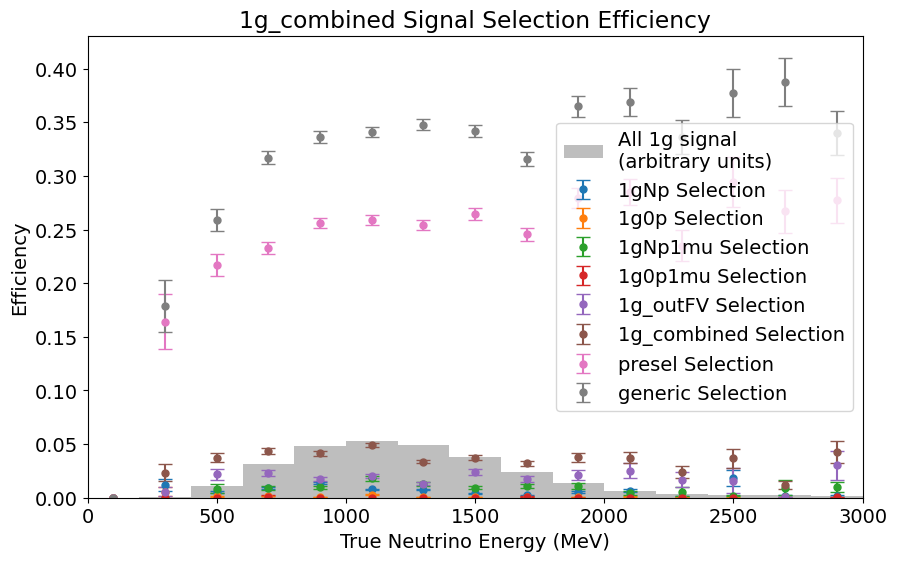

In [14]:
def frac_efficiency_stat_error(unweighted_sel, unweighted_total):
    unweighted_eff = unweighted_sel / unweighted_total
    return np.sqrt(unweighted_eff * (1 - unweighted_eff) / unweighted_total) / unweighted_eff

bins = np.linspace(0, 3000, 16)
bin_centers = (bins[:-1] + bins[1:]) / 2


# Totals
sig_counts = np.histogram(all_1g_sig_df["wc_truth_nuEnergy"], weights=all_1g_sig_df["wc_net_weight"], bins=bins)[0]
sig_counts_no_weight = np.histogram(all_1g_sig_df["wc_truth_nuEnergy"], bins=bins)[0]

plt.figure(figsize=(10, 6))

plt.hist(
    all_1g_sig_df["wc_truth_nuEnergy"],
    weights=0.7e-5*np.ones(all_1g_sig_df.shape[0]),
    bins=bins, color="tab:grey", alpha=0.5, zorder=-1,
    label=r"All 1g signal" "\n(arbitrary units)"
)

for eff_eval_cat in ["1gNp", "1g0p", "1gNp1mu", "1g0p1mu", "1g_outFV", "1g_combined", "presel", "generic"]:
    if eff_eval_cat == "1gNp":
        sig_sel_df = presel_1g_sig_1gNp_df
    elif eff_eval_cat == "1g0p":
        sig_sel_df = presel_1g_sig_1g0p_df
    elif eff_eval_cat == "1gNp1mu":
        sig_sel_df = presel_1g_sig_1gNp1mu_df
    elif eff_eval_cat == "1g0p1mu":
        sig_sel_df = presel_1g_sig_1g0p1mu_df
    elif eff_eval_cat == "1g_outFV":
        sig_sel_df = presel_1g_sig_1g_outFV_df
    elif eff_eval_cat == "1g_combined":
        sig_sel_df = presel_1g_sig_1g_combined_df
    elif eff_eval_cat == "presel":
        sig_sel_df = presel_1g_sig_df
    elif eff_eval_cat == "generic":
        sig_sel_df = generic_1g_sig_df


    sig_sel_counts = np.histogram(sig_sel_df["wc_truth_nuEnergy"], weights=sig_sel_df["wc_net_weight"], bins=bins)[0]
    sig_sel_counts_no_weight = np.histogram(sig_sel_df["wc_truth_nuEnergy"], bins=bins)[0]
    ratios = np.nan_to_num(sig_sel_counts / sig_counts)
    errs = ratios * frac_efficiency_stat_error(sig_sel_counts_no_weight, sig_counts_no_weight)
    plt.errorbar(bin_centers, ratios, yerr=errs, fmt='o', markersize=5, capsize=5, label=f"{eff_eval_cat} Selection")

plt.xlabel("True Neutrino Energy (MeV)")
plt.ylabel("Efficiency")
plt.title("1g_combined Signal Selection Efficiency")
plt.legend()
plt.xlim(bins[0], bins[-1])
#plt.ylim(0, 0.3)
plt.savefig("../plots/nc_delta_Enu_eff.pdf")


## 2D Kinematics

/tmp/ipykernel_2804319/3409274799.py:45: RuntimeWarning: invalid value encountered in scalar divide
  wc_eff_arr.append(numerator / denominator)
/tmp/ipykernel_2804319/3409274799.py:45: RuntimeWarning: invalid value encountered in scalar divide
  wc_eff_arr.append(numerator / denominator)
/tmp/ipykernel_2804319/3409274799.py:45: RuntimeWarning: invalid value encountered in scalar divide
  wc_eff_arr.append(numerator / denominator)
/tmp/ipykernel_2804319/3409274799.py:45: RuntimeWarning: invalid value encountered in scalar divide
  wc_eff_arr.append(numerator / denominator)
/tmp/ipykernel_2804319/3409274799.py:45: RuntimeWarning: invalid value encountered in scalar divide
  wc_eff_arr.append(numerator / denominator)


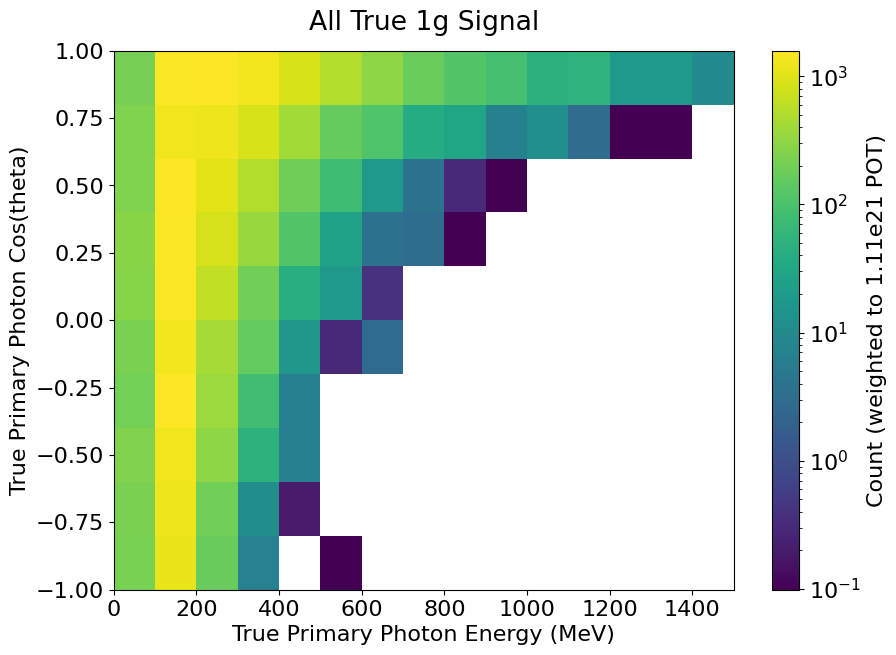

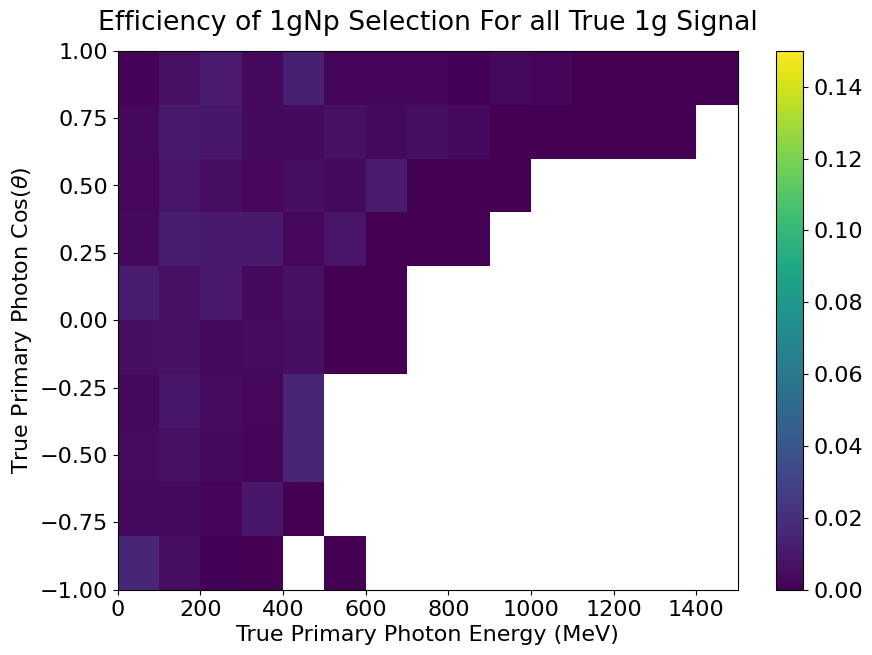

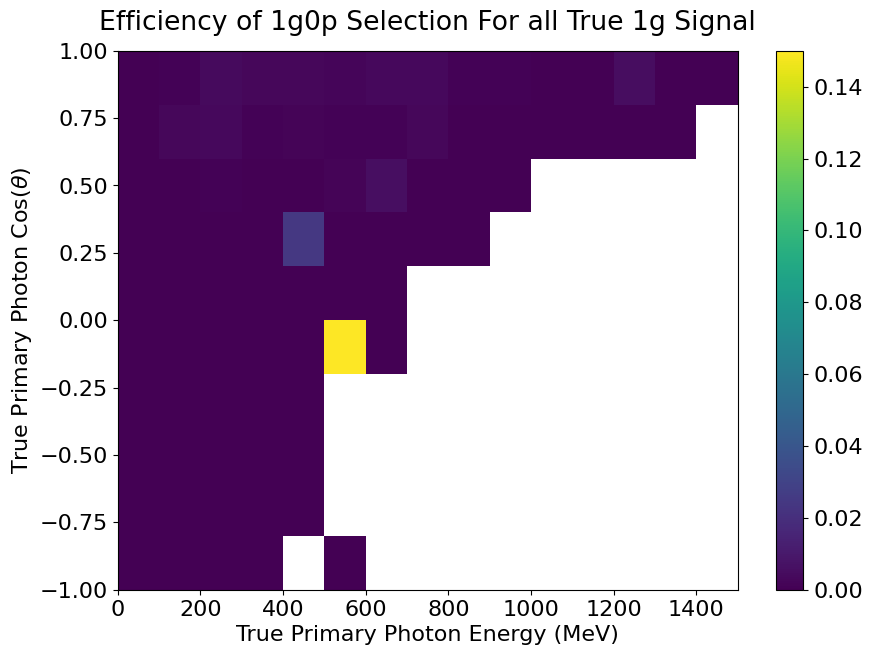

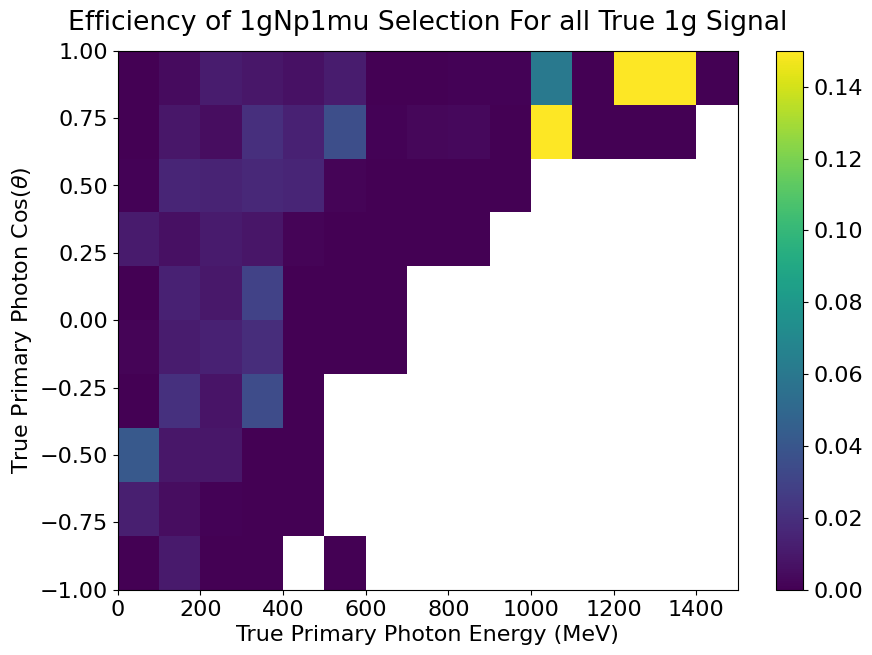

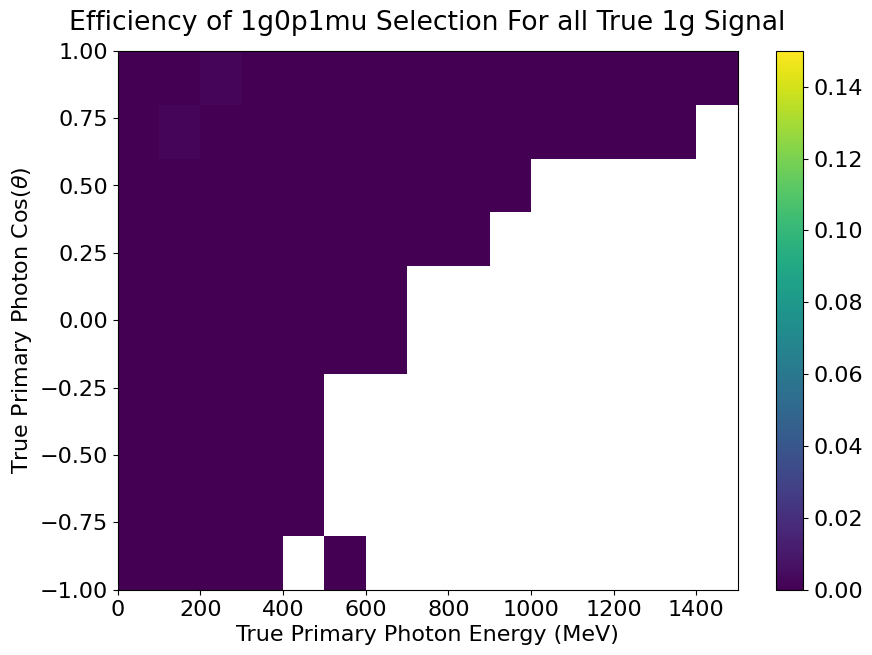

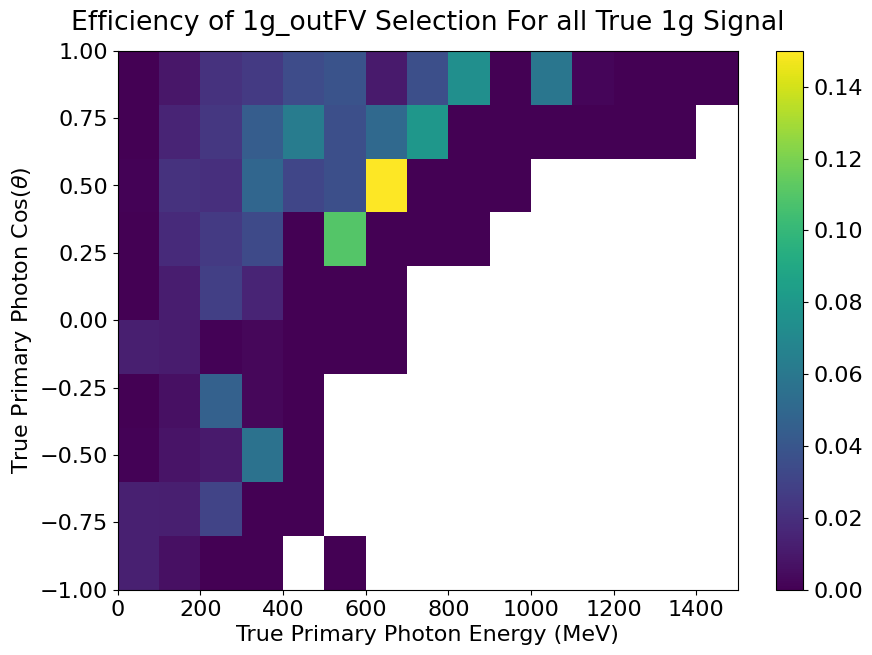

In [15]:
all_1g_sig_true_shower_energy = all_1g_sig_df["wc_true_leading_shower_energy"].to_numpy()
all_1g_sig_true_shower_costheta = all_1g_sig_df["wc_true_leading_shower_costheta"].to_numpy()
all_1g_sig_weights = all_1g_sig_df["wc_net_weight"].to_numpy()

x_bin_edges = np.linspace(0., 1500., 16)
y_bin_edges = np.linspace(-1., 1., 11)
bins = (x_bin_edges, y_bin_edges)

plt.rcParams['font.size'] = 16

plt.figure(dpi=100, figsize=(10,7))
ax = plt.gca()
plt.hist2d(all_1g_sig_true_shower_energy, all_1g_sig_true_shower_costheta, weights=all_1g_sig_weights, bins=bins, norm=mpl.colors.LogNorm())
plt.xlabel("True Primary Photon Energy (MeV)")
plt.ylabel("True Primary Photon Cos(theta)")
plt.colorbar(label="Count (weighted to 1.11e21 POT)")
plt.title("All True 1g Signal", pad=15)
plt.savefig("../plots/2d_all_1g.pdf")

for eff_eval_cat in ["1gNp", "1g0p", "1gNp1mu", "1g0p1mu", "1g_outFV"]:
    if eff_eval_cat == "1gNp":
        sig_sel_df = presel_1g_sig_1gNp_df
    elif eff_eval_cat == "1g0p":
        sig_sel_df = presel_1g_sig_1g0p_df
    elif eff_eval_cat == "1gNp1mu":
        sig_sel_df = presel_1g_sig_1gNp1mu_df
    elif eff_eval_cat == "1g0p1mu":
        sig_sel_df = presel_1g_sig_1g0p1mu_df
    elif eff_eval_cat == "1g_outFV":
        sig_sel_df = presel_1g_sig_1g_outFV_df

    counts_sig, x_edges_, y_edges_ = np.histogram2d(all_1g_sig_df["wc_true_leading_shower_energy"].to_numpy(), all_1g_sig_df["wc_true_leading_shower_costheta"].to_numpy(), 
            bins=bins, weights=all_1g_sig_df["wc_net_weight"].to_numpy())
    counts_sig_sel, x_edges_, y_edges_ = np.histogram2d(sig_sel_df["wc_true_leading_shower_energy"].to_numpy(), sig_sel_df["wc_true_leading_shower_costheta"].to_numpy(), 
            bins=bins, weights=sig_sel_df["wc_net_weight"].to_numpy())
    wc_eff_arr = []
    bin_center_x_arr = []
    bin_center_y_arr = []
    for row in range(len(y_bin_edges) - 1):
        for col in range(len(x_bin_edges) - 1):
            bin_center_x_arr.append(x_bin_edges[col] + (x_bin_edges[1] - x_bin_edges[0]) / 2.)
            bin_center_y_arr.append(y_bin_edges[row] + (y_bin_edges[1] - y_bin_edges[0]) / 2.)
            numerator = counts_sig_sel[col][row]
            denominator = counts_sig[col][row]
            wc_eff_arr.append(numerator / denominator)
    plt.figure(dpi=100, figsize=(10,7))
    ax = plt.gca()
    plt.hist2d(bin_center_x_arr, bin_center_y_arr, weights=wc_eff_arr, bins=bins)
    plt.xlabel("True Primary Photon Energy (MeV)")
    plt.ylabel(r"True Primary Photon Cos($\theta$)")
    plt.colorbar()
    plt.clim(0., 0.15)
    plt.title(f"Efficiency of {eff_eval_cat} Selection For all True 1g Signal", pad=15)
    plt.savefig(f"../plots/2d_eff_{eff_eval_cat}.pdf")
